<a href="https://colab.research.google.com/github/varunkumark1997/EVA5-Assignment/blob/master/MNIST_model_level_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target:

    Add GAP layer
    Change Convolution layer to keep parameters below 10k

Results:

    Parameters: 9,800
    Best Train Accuracy: 99.205
    Best Test Accuracy: 99.33

Analysis:

    We have achieved one of the tasks by bringing the params to under 10k
    GAP layer has given us better result than conv with 7x7 kernel as at the last layers all the pixels are important bcz the kernel has extracted this for us,
    so GAP helps in generalizing and hence better result
    But still to achieve the required accuracy and we are almost there..
    We can leverage LR Scheduler for achieving our task.

In [126]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [134]:
train_transforms = transforms.Compose(
                    [
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])
                    
test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [135]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test  = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [136]:
SEED = 1

cuda = torch.cuda.is_available()
print('is CUDA available', cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

trainloader = torch.utils.data.DataLoader(train, **dataloader_args)

testloader = torch.utils.data.DataLoader(test, **dataloader_args)

is CUDA available True


In [138]:
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('Train Data')
# print('- Numpy Shape', train.train_data.cpu().numpy().shape)
# print('- Tensor Shape', train.train_data.size())
# print('- min', torch.min(train_data))
# print('- max', torch.max(train_data))
# print('- mean', torch.mean(train_data))
# print('- std', torch.std(train_data))
# print('- var', torch.var(train_data))

# dataiterator = iter(trainloader)
# images, labels = dataiterator.next()

# print(images.shape)
# print(labels.shape)

# %matplotlib inline
# import matplotlib.pyplot as plt

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

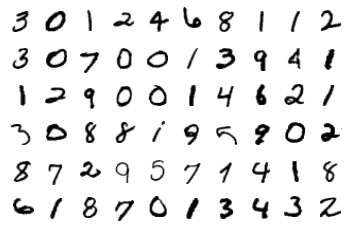

In [139]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [189]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # TRANSITION BLOCK 1
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 12

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 10

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 8
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 6

        # CONVOLUTION BLOCK 3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 4
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 4
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)        
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)        
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [190]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 32, 24, 24]             512
         MaxPool2d-8           [-1, 32, 12, 12]               0
            Conv2d-9           [-1, 16, 12, 12]             512
             ReLU-10           [-1, 16, 12, 12]               0
      BatchNorm2d-11           [-1, 16, 12, 12]              32
           Conv2d-12           [-1, 16, 10, 10]           2,304
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1

In [191]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [192]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(10):
    print('\nEPOCH:', epoch + 1)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

  0%|          | 0/469 [00:00<?, ?it/s]


EPOCH: 1


loss=0.11535421013832092 batch_id=468 Accuracy=91.29166666666667: 100%|██████████| 469/469 [00:12<00:00, 36.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0554, Accuracy: 9859/10000 (98.59%)


EPOCH: 2


loss=0.15072090923786163 batch_id=468 Accuracy=98.05166666666666: 100%|██████████| 469/469 [00:13<00:00, 35.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9885/10000 (98.85%)


EPOCH: 3


loss=0.04443027079105377 batch_id=468 Accuracy=98.46666666666667: 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9901/10000 (99.01%)


EPOCH: 4


loss=0.0343194380402565 batch_id=468 Accuracy=98.69166666666666: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9905/10000 (99.05%)


EPOCH: 5


loss=0.034649137407541275 batch_id=468 Accuracy=98.84833333333333: 100%|██████████| 469/469 [00:13<00:00, 35.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9905/10000 (99.05%)


EPOCH: 6


loss=0.01967504248023033 batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 35.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9905/10000 (99.05%)


EPOCH: 7


loss=0.00414412934333086 batch_id=468 Accuracy=98.99166666666666: 100%|██████████| 469/469 [00:12<00:00, 36.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9907/10000 (99.07%)


EPOCH: 8


loss=0.07000923156738281 batch_id=468 Accuracy=99.095: 100%|██████████| 469/469 [00:12<00:00, 36.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9914/10000 (99.14%)


EPOCH: 9


loss=0.09036801010370255 batch_id=468 Accuracy=99.165: 100%|██████████| 469/469 [00:12<00:00, 36.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)


EPOCH: 10


loss=0.03632470965385437 batch_id=468 Accuracy=99.205: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]



Test set: Average loss: 0.0233, Accuracy: 9917/10000 (99.17%)



Text(0.5, 1.0, 'Testing Accuracy')

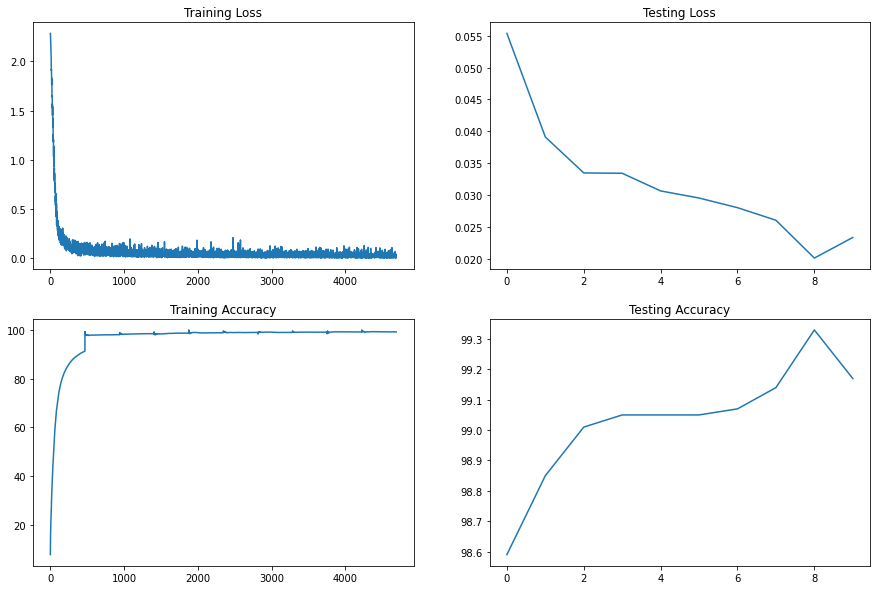

In [193]:
fig, axis = plt.subplots(2, 2, figsize=(15,10))
axis[0, 0].plot(train_losses)
axis[0, 0].set_title("Training Loss")
axis[1 ,0].plot(train_acc)
axis[1, 0].set_title("Training Accuracy")
axis[0 ,1].plot(test_losses)
axis[0, 1].set_title("Testing Loss")
axis[1 ,1].plot(test_acc)
axis[1, 1].set_title("Testing Accuracy")